## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [7]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [9]:
import findspark
findspark.init()

from pyspark import SparkContext
sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['/Users/prahalarora/Desktop/lib/numpy_pack.py','/Users/prahalarora/Desktop/lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [10]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [12]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBSSSB'
meas='TOBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
1186
+-------------------+------------------+------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+-------------------+-----------+-----------+------+--------------------+------+
|            coeff_1|           coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|           res_mean|    station|  total_var|undefs|              vector|  year|
+-------------------+------------------+------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+-------------------+-----------+-----------+------+--------------------+------+
|-332.17891213891136| -189.460118266104|-401.3346523377105|    661.4|SSSBSSSB| 37.8792|-121.9303|       TOBS|0.9125218237494869| 0.883268453605124|0.7579289465907345|0.15416292017944797|U

In [14]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+-------------------+
|    station|latitude|longitude|elevation|            coeff_1|
+-----------+--------+---------+---------+-------------------+
|USC00045915| 37.8792|-121.9303|    661.4|-332.17891213891136|
|USC00049423| 37.8833|-122.0333|     74.7|  444.7088248933877|
|USC00040227| 38.0167|-121.7667|      8.5|  92.79922693091893|
|USC00045032| 38.1061|-121.2878|     12.2| -86.34616654327111|
+-----------+--------+---------+---------+-------------------+
only showing top 4 rows



In [15]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
23,USC00040227,38.0167,-121.7667,8.5,30,395.766792
33,USC00040232,37.9856,-121.7458,18.3,44,-193.065422


In [16]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#d60000'

## Map

In [17]:
min_lat,max_lat,min_long,max_long = box = (42.1103, 42.6167, -72.6, -70.8)


In [27]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    print index, _count, _lat, _long, _coef, get_color(_coef)
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)

#L.tileLayer.provider('Stamen.Watercolor').addTo(m)
m    

23 30 38.0167 -121.7667 395.766791937 #eeff09
33 44 37.9856 -121.7458 -193.065421691 #09f0ee
25 41 37.8744 -122.2606 -445.631663993 #0074ff
0 9 38.1167 -121.7 -666.235079458 #000cff
14 25 37.5833 -122.35 256.201069951 #b7ff40
20 20 37.9833 -122.0692 1165.45223846 #800000
12 17 38.0333 -122.2167 -262.359405982 #00ccff
8 5 38.2 -122.3 -863.901948804 #0000b2
37 7 37.5422 -122.0158 406.62964539 #f1fc06
16 6 38.15 -121.9667 -645.196395663 #0014ff
21 2 38.05 -122.5 541.76029179 #ffc100
4 64 37.9567 -122.5447 356.729338722 #deff19
27 67 37.6922 -121.7692 255.719965542 #b7ff40
6 56 38.1061 -121.2878 844.139934357 #ff3800
15 4 38.0333 -121.5667 976.263554176 #e40000
38 11 37.8 -121.2 -536.300400889 #0048ff
1 24 38.0167 -122.1333 -504.134595655 #0058ff
29 43 38.0131 -122.1142 -183.407815665 #0cf4eb
36 58 37.8792 -121.9303 -386.314046677 #0090ff
19 55 37.5147 -122.0325 -478.23314865 #0064ff
9 20 37.8667 -120.8667 -506.335128446 #0058ff
41 17 37.7833 -122.1667 -156.930041588 #16ffe1
42 15 37.7983 

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

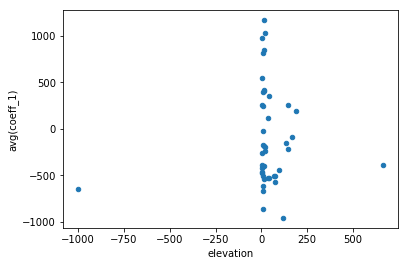

In [28]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

In [21]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']